In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
from connector import spark_connector

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [4]:
spark_connector?

Init signature:
spark_connector(
    exec_inst: int = 100,
    exec_cores: int = 5,
    aloc_max: int = 500,
    memory_exec: int = 25,
    name: object = 'utopialvo',
    rootdir: object = 'remote_dir_in_hdft',
    enable_graphframes: bool = False,
    enable_clickhouse: bool = False,
    enable_postgres: bool = False,
    dynamic_allocation: bool = False,
    intensive_mode: bool = False,
    marshal_mode: bool = True,
    yarn: bool = True,
) -> None
Docstring:     
Класс стандартного подключения к Spark

exec_inst - количество контейнеров
exec_cores - количество ядер в контейнере
aloc_max - максимальное количество ядер для dynamic_allocation (если он вкл)
memory_exec - количество памяти в контейнере
name - название подключения для упрощения логгирования подключений в кластере
rootdir - корневая папка в HDFS 
enable_graphframes - включить работу с graphframes
enable_clickhouse - включить работу с clickhouse
enable_postgres - включить работу с postgres
dynamic_allocation - включить д

In [5]:
con = spark_connector(exec_inst=100, exec_cores=5, memory_exec=25, enable_graphframes=True, marshal_mode=False, yarn = False)

In [6]:
con.spark

In [7]:
from sklearn.datasets import make_blobs

In [8]:
X, y, c = make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=1.0, center_box=(-15.0, 15.0), shuffle=True, random_state=0, return_centers=True)

In [9]:
data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(X.shape[1])])
data['y'] = y
data = data.merge(pd.DataFrame(c, columns=[f'centroids_{i+1}' for i in range(X.shape[1])]).reset_index(), left_on='y', right_on='index', how='left').drop('index', axis=1)

In [10]:
data

,x1,x2,y,centroids_1,centroids_2
0,-1.329773,12.469129,3,-1.872384,11.753190
1,-1.761412,4.622971,2,-2.290356,4.376823
2,3.854307,2.375934,1,3.082901,1.346495
3,3.688021,2.242051,1,3.082901,1.346495
4,1.562130,7.038635,0,1.464405,6.455681
...,...,...,...,...,...
995,2.612868,1.129764,1,3.082901,1.346495
996,13.101165,-4.600878,4,13.909883,-3.496754
997,-1.783117,4.260594,2,-2.290356,4.376823
998,-2.421882,10.654619,3,-1.872384,11.753190


In [11]:
import seaborn as sns

<Axes: xlabel='x1', ylabel='x2'>

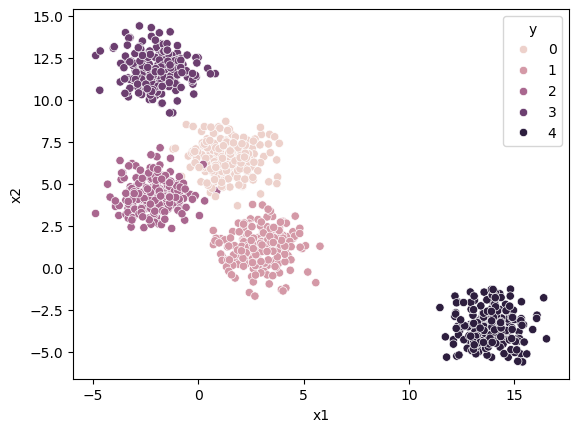

In [12]:
sns.scatterplot(x=data.x1, y=data.x2, hue=data.y)

<Axes: xlabel='centroids_1', ylabel='centroids_2'>

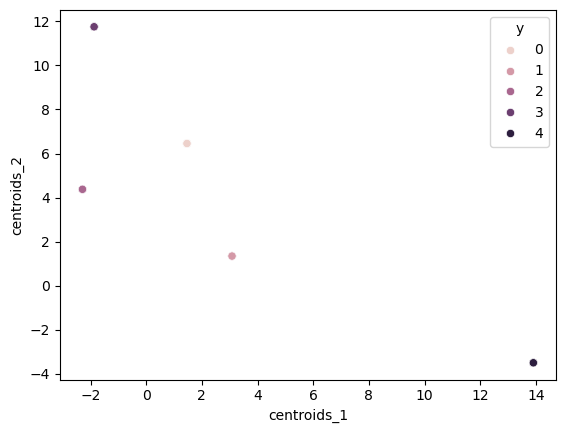

In [13]:
sns.scatterplot(x=data.centroids_1, y=data.centroids_2, hue=data.y)

In [15]:
data2 = data.reset_index(names='index_train')#.drop(['y','centroids_1','centroids_2'], axis=1)

In [16]:
data2

,index_train,x1,x2,y,centroids_1,centroids_2
0,0,-1.329773,12.469129,3,-1.872384,11.753190
1,1,-1.761412,4.622971,2,-2.290356,4.376823
2,2,3.854307,2.375934,1,3.082901,1.346495
3,3,3.688021,2.242051,1,3.082901,1.346495
4,4,1.562130,7.038635,0,1.464405,6.455681
...,...,...,...,...,...,...
995,995,2.612868,1.129764,1,3.082901,1.346495
996,996,13.101165,-4.600878,4,13.909883,-3.496754
997,997,-1.783117,4.260594,2,-2.290356,4.376823
998,998,-2.421882,10.654619,3,-1.872384,11.753190


In [17]:
train_df = con.spark.createDataFrame(data2)

# Normalizer

In [18]:
from norm import Normalizer

In [19]:
normalizer = Normalizer(
    methods={
        'x1': 'zscore',
        'x2': 'zscore',
        'centroids_1': 'minmax',
        'centroids_2': 'minmax',
    },
    columns=train_df.drop('index_train','y').columns
)
normalizer.fit(train_df)

In [20]:
df_normalized = normalizer.transform(train_df)

In [21]:
print(normalizer.stats)

{'x1': {'method': 'zscore', 'params': (2.8300614079849757, 5.943594186778003)}, 'x2': {'method': 'zscore', 'params': (4.072334891779366, 5.218754895827069)}, 'centroids_1': {'method': 'minmax', 'params': (-2.290356019832858, 13.90988281503088)}, 'centroids_2': {'method': 'minmax', 'params': (-3.496754435226668, 11.753190023462395)}}


In [22]:
df_normalized = df_normalized.toPandas()

<Axes: xlabel='x1', ylabel='x2'>

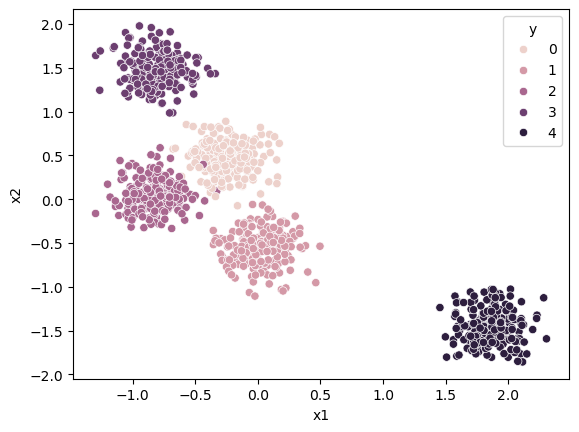

In [23]:
sns.scatterplot(x=df_normalized.x1, y=df_normalized.x2, hue=df_normalized.y)

<Axes: xlabel='centroids_1', ylabel='centroids_2'>

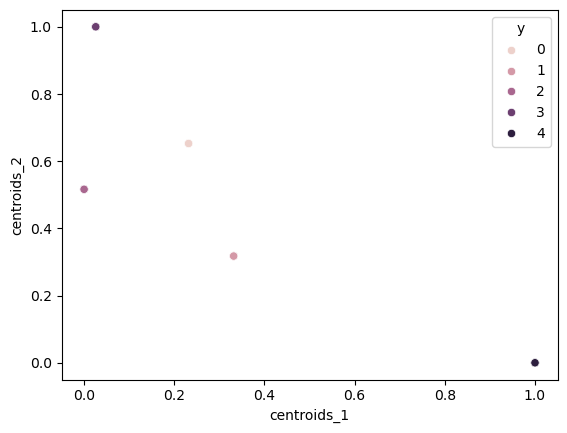

In [24]:
sns.scatterplot(x=df_normalized.centroids_1, y=df_normalized.centroids_2, hue=df_normalized.y)

In [25]:
normalizer = Normalizer(
    method='minmax',
    columns=train_df.drop('index_train','y').columns
)
normalizer.fit(train_df)
df_normalized = normalizer.transform(train_df)

In [26]:
print(normalizer.stats)

{'x1': {'method': 'minmax', 'params': (-4.873152652802803, 16.53045666104912)}, 'x2': {'method': 'minmax', 'params': (-5.620644453272227, 14.396125744477136)}, 'centroids_1': {'method': 'minmax', 'params': (-2.290356019832858, 13.90988281503088)}, 'centroids_2': {'method': 'minmax', 'params': (-3.496754435226668, 11.753190023462395)}}


In [27]:
df_normalized = df_normalized.toPandas()

<Axes: xlabel='x1', ylabel='x2'>

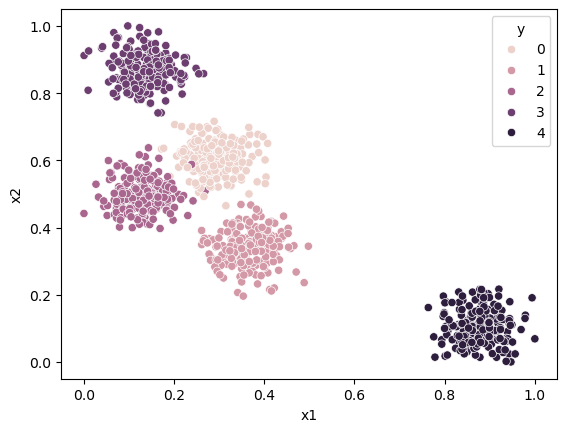

In [28]:
sns.scatterplot(x=df_normalized.x1, y=df_normalized.x2, hue=df_normalized.y)

In [29]:
normalizer = Normalizer(
    method='range',
    columns=train_df.drop('index_train','y').columns
)
normalizer.fit(train_df)
df_normalized = normalizer.transform(train_df)

In [30]:
print(normalizer.stats)

{'x1': {'method': 'range', 'params': (-4.873152652802803, 16.53045666104912, 2.8300614079849757)}, 'x2': {'method': 'range', 'params': (-5.620644453272227, 14.396125744477136, 4.072334891779366)}, 'centroids_1': {'method': 'range', 'params': (-2.290356019832858, 13.90988281503088, 2.858889906609542)}, 'centroids_2': {'method': 'range', 'params': (-3.496754435226668, 11.753190023462395, 4.08708709226299)}}


In [31]:
df_normalized = df_normalized.toPandas()

<Axes: xlabel='x1', ylabel='x2'>

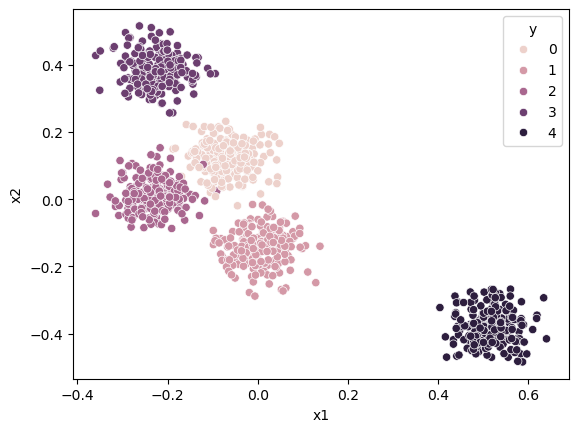

In [32]:
sns.scatterplot(x=df_normalized.x1, y=df_normalized.x2, hue=df_normalized.y)

In [33]:
con.stop_spark()

time: 2025-02-22 20:53:18.649373
del
stop
